In [2]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


Loading and processing the training data

In [3]:
# load the csv file lab, display head to examine
train_file = 'train.csv'
train_csv = pd.read_csv(train_file)
# randomize dataframe rows to prepare for dividing into train/valid/test sets
data = train_csv.sample(frac = 1)
# display for a quick check
data.head()


,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
356,588,Eucalyptus_Neglecta,0.066406,0.121090,0.015625,0.001953,0.000000,0.160160,0.023438,0.000000,...,0.039062,0.0,0.021484,0.006836,0.016602,0.0,0.0,0.012695,0.000000,0.076172
161,282,Populus_Nigra,0.017578,0.013672,0.058594,0.003906,0.009766,0.033203,0.046875,0.005859,...,0.032227,0.0,0.013672,0.002930,0.030273,0.0,0.0,0.002930,0.000000,0.011719
632,1001,Populus_Grandidentata,0.001953,0.009766,0.126950,0.000000,0.000000,0.017578,0.017578,0.005859,...,0.047852,0.0,0.007812,0.000000,0.005859,0.0,0.0,0.001953,0.000000,0.016602
863,1381,Ulmus_Bergmanniana,0.000000,0.000000,0.003906,0.021484,0.058594,0.000000,0.017578,0.000000,...,0.000000,0.0,0.000000,0.056641,0.015625,0.0,0.0,0.123050,0.016602,0.000000
418,684,Quercus_Crassipes,0.037109,0.015625,0.021484,0.019531,0.000000,0.107420,0.015625,0.000000,...,0.026367,0.0,0.067383,0.000000,0.000000,0.0,0.0,0.000000,0.019531,0.020508


In [62]:
#get the different species categories
categories = train_csv.species.unique()
#print the 1st 10 to verify
print "First 10 categories: ", categories[:10]
#print length of array to ensure 99 categories are there
print "Number of categories:", len(categories) 
print type(categories)

#convert string categories for training set into indices of the categories array
labels_dense = [np.where(i == categories)[0][0] for i in data.species]


#convert dense labels to one-hot-encoding
labels = np.eye(len(categories))[labels_dense]

First 10 categories:  ['Acer_Opalus' 'Pterocarya_Stenoptera' 'Quercus_Hartwissiana'
 'Tilia_Tomentosa' 'Quercus_Variabilis' 'Magnolia_Salicifolia'
 'Quercus_Canariensis' 'Quercus_Rubra' 'Quercus_Brantii' 'Salix_Fragilis']
Number of categories: 99
<type 'numpy.ndarray'>
66


Split the csv data into training, test, and validation sets

In [83]:
# split into train/test datasets. 
# test here means my own private test set to get my own idea of the accuracy, not the given test set
train_length = int(len(data) * .8)

train_ = data[:train_length]
test_data = data[train_length:]
print("Total data: {} Training and validation examples: {} Test examples: {}".format(len(data), len(train_), len(test_data)))
train_l = labels[:train_length]
test_labels = labels[train_length:]
test_labels_readable = np.array(data.species[train_length:])
test_image_number = np.array(data.id[train_length:])
print("test labels readable: ", test_labels_readable[0])
print("Total labels: {} Training and validation labels: {} Test labelss: {}".format(len(labels), len(train_l), len(test_labels)))

#further split training data and labels into training and validation sets

train_length = int(len(train_) * .8)

train_data = train_[:train_length]
valid_data = train_[train_length:]
print("Total Training and validation examples: {} Training examples: {} Validation examples: {}".format(len(train_), len(train_data), len(valid_data)))
train_labels = train_l[:train_length]
valid_labels = train_l[train_length:]
print("Total Training and validationl labels: {} Training labels: {} Validation labels: {}".format(len(train_l), len(train_labels), len(valid_labels)))
print("Shape of training labels: {}".format(train_labels.shape))


Total data: 990 Training and validation examples: 792 Test examples: 198
('test labels readable: ', 'Eucalyptus_Urnigera')
Total labels: 990 Training and validation labels: 792 Test labelss: 198
Total Training and validation examples: 792 Training examples: 633 Validation examples: 159
Total Training and validationl labels: 792 Training labels: 633 Validation labels: 159
Shape of training labels: (633, 99)


Now for the image data: I will grab the image for all the ids in the training and test set, coverting them from jpg to binary.

In [84]:
def make_image_set(csv_set):
    images = []
    for i in csv_set.id:
        im_gray = cv2.imread('images/' + str(i) + ".jpg", cv2.IMREAD_GRAYSCALE)
        thres, im_bw = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        im_bw = np.array(im_bw)
        images.append(im_bw)
    return np.array(images)

train_images = make_image_set(train_data)
valid_images = make_image_set(valid_data)
test_images = make_image_set(test_data)



 # conversion to binary courtesy of  http://stackoverflow.com/a/7637687/399741

In [102]:
#modified from function found a tcourtesy ofhttps://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
def plot_images(images, cls_true, image_no):    

    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=2, wspace=2)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='gray')

        # Show true and predicted classes.
        xval = str(cls_true[i]) + ", image number: " + str(image_no[i])
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xval)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

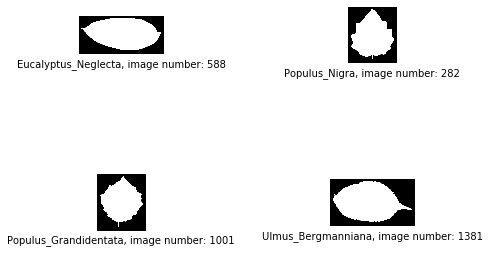

In [117]:
train_l = np.array(data.species[:4])
image_no = np.array(data.id[:4])
# Plot the images and labels using our helper-function above to visually verify.
plot_images(images=train_images[:4], cls_true=train_l, image_no = image_no)

    

Need to make all the images the same size to run a CNN. Since CNNs are location invariant, preserving image shape is more important than centering it or preserving its location. So I will add black pixeles to the bottom and right edges of the image matrices so that they are of uniform size.

In [118]:
# get the max height and width of all the images in the image dataset
max_height = 0
max_width = 0

def getMaxShape(data):
    max_height = 0
    max_width = 0
    for i in data:
        if i.shape[0] > max_height:
            max_height = i.shape[0]
        if i.shape[1] > max_width:
            max_width = i.shape[1]
    return max_height, max_width
    
maxTrain = getMaxShape(train_images)
maxValid = getMaxShape(valid_images)
maxTest = getMaxShape(test_images)
maxdims = [maxTrain, maxValid, maxTest]

from operator import itemgetter
max_height, max_width = max(maxdims, key=itemgetter(0))

        
print "Max image height: ", max_height
print "Max image width: ", max_width

#to make square images, choose the largest
image_size = max(max_height, max_width)

# add the padding
def add_padding(image, height, width):
    add_bottom = height - image.shape[0]
    add_right = width - image.shape[1]
    npad = ((0, add_bottom), (0, add_right))
    return np.pad(image, pad_width=npad, mode='constant', constant_values=0)

# run add_padding on all the images
train_images_padded = np.array([add_padding(i, image_size, image_size) for i in train_images])
valid_images_padded = np.array([add_padding(i, image_size, image_size) for i in valid_images])
test_images_padded = np.array([add_padding(i, image_size, image_size) for i in test_images])

#resize images to something manageable
# def resize(img, factor):
#     return cv2.resize(img, (int(factor*img.shape[1]),int(factor*img.shape[0])), 
#                      interpolation = cv2.INTER_AREA)

# factor = .05

def resize(img, factor):
    return cv2.resize(img, (400, 400), 
                     interpolation = cv2.INTER_AREA)

train_images_resized = np.array([resize(i, factor) for i in train_images_padded])
valid_images_resized = np.array([resize(i, factor) for i in valid_images_padded])
test_images_resized = np.array([resize(i, factor) for i in test_images_padded])

#get new width and height for later calculations
height, width = train_images_resized[108].shape


print ("width: {} height: {}".format(width, height))




Max image height:  1089
Max image width:  1633
width: 400 height: 400


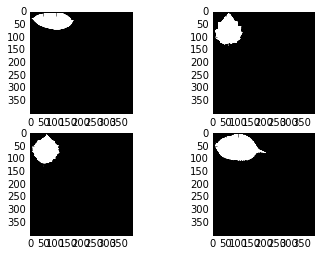

In [120]:
#visualize a few examples, visually verify that padding was added

fig = plt.figure()
counter = 1
for ima in train_images_resized[:4]:
    a = fig.add_subplot(2,2, counter)
    plt.imshow(ima, cmap='gray')
    counter +=1


I need to convert the data arrays into a Tensorflow-friendly shape with 4 dimensions; each image will have width, height, and depth(for the number of color channels).

In [121]:
num_channels = 1 #depth of image for grayscale

#a helper function for conversion, courtesy of Udacity examples in Tensorflow source GitHub
def reformat(dataset):
  dataset = dataset.reshape(
    (-1, height, width, num_channels)).astype(np.float32)
  return dataset

train_data = reformat(train_images_resized)
valid_data = reformat(valid_images_resized)
test_data = reformat(test_images_resized)

print train_data.shape

(633, 400, 400, 1)


In [122]:
#an accuracy helper function
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Now to create the model graph with two convolutional layers followed by a fully connected layer.

In [123]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
num_labels = 99

graph = tf.Graph()
with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, height, width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_data)
  tf_test_dataset = tf.constant(test_data)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [height // 4 * width // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Now to train the model.

In [ ]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_data[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 406.414246
Minibatch accuracy: 0.0%
Validation accuracy: 2.5%
Minibatch loss at step 50: 4.592008
Minibatch accuracy: 6.2%
Validation accuracy: 0.0%
Minibatch loss at step 100: 4.589972
Minibatch accuracy: 0.0%
Validation accuracy: 0.0%
